In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "./datasets/simulation_data.csv"
df = pd.read_csv(file_path)

print("Dataset Shape:", df.shape)
print("Column Names:", df.columns)
print("\nDataset Preview:")
print(df.head())

print("\nSummary Statistics:")
print(df.describe())

missing_values = df.isnull().sum()
print("\nMissing Values:\n", missing_values)

Dataset Shape: (1000000, 8)
Column Names: Index(['wheel_index', 'slip_ratio', 'angular_velocity', 'linear_speed',
       'current_brake_torque', 'current_drive_torque', 'desired_brake_torque',
       'desired_drive_torque'],
      dtype='object')

Dataset Preview:
   wheel_index  slip_ratio  angular_velocity  linear_speed  \
0            0   -1.000000     3.207450e-228        5.0000   
1            1   -1.000000     3.207450e-228        5.0000   
2            2   -1.000000     3.207450e-228        5.0000   
3            3   -1.000000     3.207450e-228        5.0000   
4            0   -0.457664      8.861600e+00        4.9019   

   current_brake_torque  current_drive_torque  desired_brake_torque  \
0                   0.0               3.30000                   0.0   
1                   0.0               3.30000                   0.0   
2                   0.0               3.30000                   0.0   
3                   0.0               3.30000                   0.0   
4      

C:\Users\gc042\AppData\Local\Temp\ipykernel_40284\4090915173.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Some values in desired drive torque have mixed characters and numbers making it impossible to convert them straightforwardly into float, let's remove them:

In [9]:
df['desired_drive_torque'] = df['desired_drive_torque'].replace(
    r'[^\d.-]', '', regex=True).astype(float)

print("Cleaned desired_drive_torque column:")
print(df['desired_drive_torque'].head())

print("Dataset Shape:", df.shape)
print("Column Names:", df.columns)
print("\nDataset Preview:")
print(df.head())

Cleaned desired_drive_torque column:
0    6.60000
1    6.60000
2    6.60000
3    6.60000
4    6.64598
Name: desired_drive_torque, dtype: float64
Dataset Shape: (1000000, 8)
Column Names: Index(['wheel_index', 'slip_ratio', 'angular_velocity', 'linear_speed',
       'current_brake_torque', 'current_drive_torque', 'desired_brake_torque',
       'desired_drive_torque'],
      dtype='object')

Dataset Preview:
   wheel_index  slip_ratio  angular_velocity  linear_speed  \
0            0   -1.000000     3.207450e-228        5.0000   
1            1   -1.000000     3.207450e-228        5.0000   
2            2   -1.000000     3.207450e-228        5.0000   
3            3   -1.000000     3.207450e-228        5.0000   
4            0   -0.457664      8.861600e+00        4.9019   

   current_brake_torque  current_drive_torque  desired_brake_torque  \
0                   0.0               3.30000                   0.0   
1                   0.0               3.30000                   0.0   
2   

Now all the values have been fixed, let's proceed with analysing the distribution:

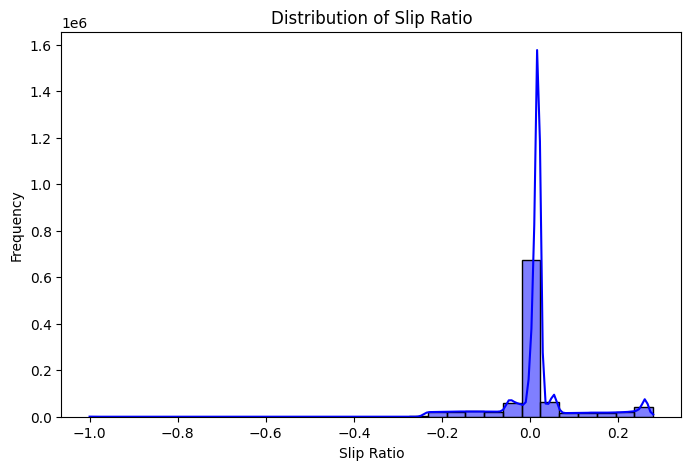

In [10]:
plt.figure(figsize=(8, 5))
sns.histplot(df['slip_ratio'], kde=True, bins=30, color='blue')
plt.title("Distribution of Slip Ratio")
plt.xlabel("Slip Ratio")
plt.ylabel("Frequency")
plt.show()

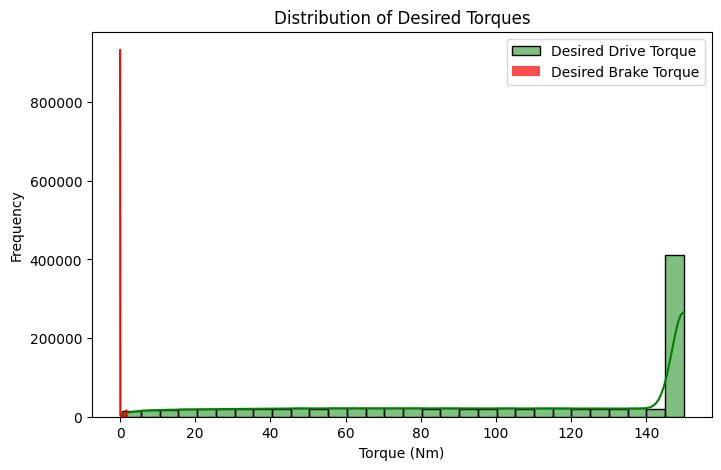

In [11]:
plt.figure(figsize=(8, 5))
sns.histplot(df['desired_drive_torque'], kde=True, bins=30, color='green', label='Desired Drive Torque')
sns.histplot(df['desired_brake_torque'], kde=True, bins=30, color='red', label='Desired Brake Torque', alpha=0.7)
plt.title("Distribution of Desired Torques")
plt.xlabel("Torque (Nm)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### **1. Slip Ratio Distribution**
- The **slip ratio** distribution is highly concentrated around `0` with a few outliers.
- Observations:
  - The distribution is right-skewed with a long tail on the positive side.
  - Significant clustering near `0.0`, which is expected if the system is mostly maintaining optimal traction (low slip).

#### **Actionable Steps:**
- Investigate outliers with extreme slip values (e.g., near `-1.0` or `0.25+`).
- Check how these extreme slip ratios affect `desired_*` values.

---

### **2. Desired Torques Distribution**
- **Desired Drive Torque:** Peaks strongly near `150 Nm`, which indicates frequent saturation at the maximum torque limit.
- **Desired Brake Torque:** Mostly clustered around `0`, indicating minimal braking.

#### **Observations:**
- The high frequency of `desired_drive_torque` at `150 Nm` might indicate the vehicle often operates at full drive power.
- The clustering of `desired_brake_torque` around `0` aligns with minimal braking under normal conditions.

#### **Actionable Steps:**
- Ensure torque saturation is reasonable and expected under simulated conditions.
- Investigate conditions leading to high `desired_drive_torque`.

# Investigate Outliers in Slip Ratio

Number of outliers in slip_ratio: 316

Outliers in slip_ratio:
      wheel_index  slip_ratio  angular_velocity  linear_speed  \
0               0        -1.0     3.207450e-228           5.0   
1               1        -1.0     3.207450e-228           5.0   
2               2        -1.0     3.207450e-228           5.0   
3               3        -1.0     3.207450e-228           5.0   
4000            0        -1.0     1.333740e-247          10.0   

      current_brake_torque  current_drive_torque  desired_brake_torque  \
0                      0.0                   3.3                   0.0   
1                      0.0                   3.3                   0.0   
2                      0.0                   3.3                   0.0   
3                      0.0                   3.3                   0.0   
4000                   0.0                   3.3                   0.0   

      desired_drive_torque  
0                      6.6  
1                      6.6  
2             

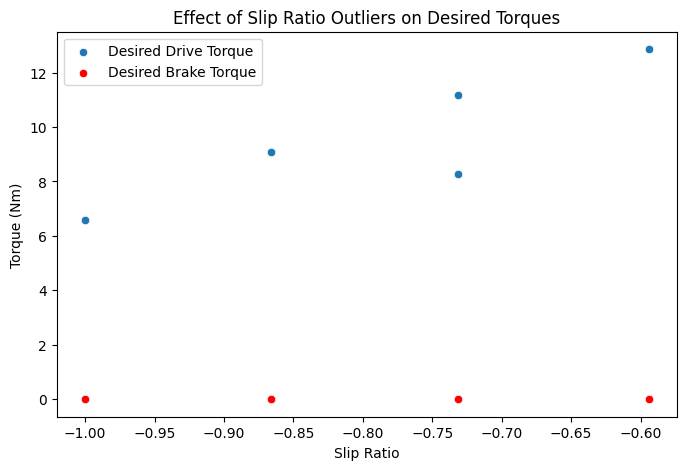

In [12]:
outliers = df[(df['slip_ratio'] < -0.5) | (df['slip_ratio'] > 0.5)]
print(f"Number of outliers in slip_ratio: {len(outliers)}")

print("\nOutliers in slip_ratio:")
print(outliers.head())

plt.figure(figsize=(8, 5))
sns.scatterplot(x='slip_ratio', y='desired_drive_torque', data=outliers, label='Desired Drive Torque')
sns.scatterplot(x='slip_ratio', y='desired_brake_torque', data=outliers, label='Desired Brake Torque', color='red')
plt.title("Effect of Slip Ratio Outliers on Desired Torques")
plt.xlabel("Slip Ratio")
plt.ylabel("Torque (Nm)")
plt.legend()
plt.show()

# Explore Relationships Between Features

c:\Users\gc042\OneDrive\Desktop\GitHub\traction_control\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


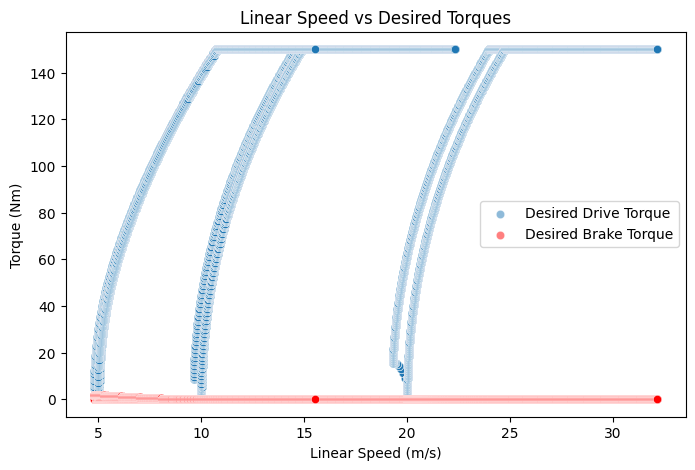

c:\Users\gc042\OneDrive\Desktop\GitHub\traction_control\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


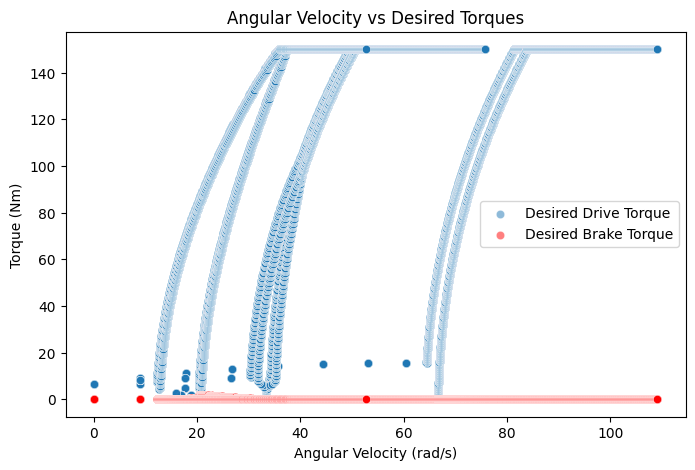

In [13]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='linear_speed', y='desired_drive_torque', data=df, alpha=0.5, label='Desired Drive Torque')
sns.scatterplot(x='linear_speed', y='desired_brake_torque', data=df, alpha=0.5, color='red', label='Desired Brake Torque')
plt.title("Linear Speed vs Desired Torques")
plt.xlabel("Linear Speed (m/s)")
plt.ylabel("Torque (Nm)")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(x='angular_velocity', y='desired_drive_torque', data=df, alpha=0.5, label='Desired Drive Torque')
sns.scatterplot(x='angular_velocity', y='desired_brake_torque', data=df, alpha=0.5, color='red', label='Desired Brake Torque')
plt.title("Angular Velocity vs Desired Torques")
plt.xlabel("Angular Velocity (rad/s)")
plt.ylabel("Torque (Nm)")
plt.legend()
plt.show()

### **1. Linear Speed vs Desired Torques**
- **Desired Drive Torque:**
  - Shows a clear grouping, with distinct arcs corresponding to specific regimes of linear speed.
  - The torque reaches saturation (maximum value) for higher linear speeds.
- **Desired Brake Torque:**
  - Stays clustered near 0, which is expected as braking is rarely applied unless there’s excessive slip.

**Insights:**
- Drive torque increases with linear speed until it saturates, suggesting a smooth and consistent relationship.
- Brake torque is minimal under normal conditions, reflecting proper traction control behavior.

---

### **2. Angular Velocity vs Desired Torques**
- **Desired Drive Torque:**
  - Similar arc-like groupings, with a clear relationship between angular velocity and drive torque.
  - Saturation of drive torque is evident at higher angular velocities.
- **Desired Brake Torque:**
  - Mostly clustered at 0, with rare deviations when braking is required.

**Insights:**
- The relationship between angular velocity and drive torque aligns with expected wheel dynamics, where higher wheel speeds (angular velocity) demand more torque.
- Minimal brake torque at low angular velocities further validates correct system behavior.

**Next Steps:** Creating new features correlating speed and velocity, so that the model has more patterns to learn. Excess drive torque will be the delta for the current torque and the desired, allowing the model to catch the relationship between the two and then the slip_deviation.

In [15]:
df['speed_to_velocity_ratio'] = df['linear_speed'] / (df['angular_velocity'] + 1e-6)
df['excess_drive_torque'] = df['current_drive_torque'] - df['desired_drive_torque']
df['slip_deviation'] = df['slip_ratio'] - 0.1

print("\nFeature Preview:")
print(df[['speed_to_velocity_ratio', 'excess_drive_torque', 'slip_deviation']].head())

output_file = "./datasets/simulation_data_cleaned.csv"
df.to_csv(output_file, index=False)

print(f"Cleaned and engineered dataset saved to {output_file}")


Feature Preview:
   speed_to_velocity_ratio  excess_drive_torque  slip_deviation
0             5.000000e+06             -3.30000       -1.100000
1             5.000000e+06             -3.30000       -1.100000
2             5.000000e+06             -3.30000       -1.100000
3             5.000000e+06             -3.30000       -1.100000
4             5.531619e-01             -1.67299       -0.557664
Cleaned and engineered dataset saved to ./datasets/simulation_data_cleaned.csv
